In [2]:
import torch
import numpy as np
import random
from IPython import display
from matplotlib import pyplot as plt
import torch.utils.data as Data
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"  #防止jupyter崩溃

手动生成回归任务的数据集，训练集为大小为7000，测试集为3000样本特征维度p为500

In [3]:
#自定义数据---训练集
num_inputs = 500
#一共一万个数据，前7000为训练集，后3000为测试集
num_examples = 10000
true_w = torch.ones(500,1)*0.0056
true_b = 0.028
x_features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)
y_labels = torch.mm(x_features,true_w) + true_b
y_labels += torch.tensor(np.random.normal(0, 0.01, size=y_labels.size()), dtype=torch.float)
#训练集
trainfeatures =x_features[:7000]
trainlabels = y_labels[:7000]
print(trainfeatures.shape)
#测试集
testfeatures =x_features[7000:]
testlabels = y_labels[7000:]
print(testfeatures.shape)

torch.Size([7000, 500])
torch.Size([3000, 500])


In [4]:
#读取数据
batch_size = 50
# 将训练数据的特征和标签组合
dataset = Data.TensorDataset(trainfeatures, trainlabels)
# 把 dataset 放入 DataLoader
train_iter = Data.DataLoader(
    dataset=dataset, # torch TensorDataset format
    batch_size=batch_size, # mini batch size
    shuffle=True, # 是否打乱数据 (训练集一般需要进行打乱)
    num_workers=0, # 多线程来读数据， 注意在Windows下需要设置为0
)
# 将测试数据的特征和标签组合
dataset = Data.TensorDataset(testfeatures, testlabels)
# 把 dataset 放入 DataLoader
test_iter = Data.DataLoader(
    dataset=dataset, # torch TensorDataset format
    batch_size=batch_size, # mini batch size
    shuffle=True, # 是否打乱数据 (训练集一般需要进行打乱)
    num_workers=0, # 多线程来读数据， 注意在Windows下需要设置为0
)

In [5]:
#初始化参数
num_hiddens,num_outputs = 256,1

W1 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens,num_inputs)), dtype=torch.float32)
b1 = torch.zeros(1, dtype=torch.float32)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_outputs,num_hiddens)), dtype=torch.float32)
b2 = torch.zeros(1, dtype=torch.float32)
params =[W1,b1,W2,b2]
for param in params:
    param.requires_grad_(requires_grad=True)

In [6]:
def relu(x):
    x = torch.max(input=x,other=torch.tensor(0.0))
    return x

In [7]:
#定义模型
def net(X):
    X = X.view((-1,num_inputs))
    H = relu(torch.matmul(X,W1.t())+b1)
    return torch.matmul(H,W2.t())+b2

In [8]:
#定义最小化均方误差
loss = torch.nn.MSELoss()

#定义随机梯度下降法
def SGD(paras,lr,batch_size):
    for param in params:
        param.data -= lr * param.grad/batch_size

In [9]:
#测试集准确率
def evaluate_accuracy(data_iter,net):
    acc_sum,n = 0.0,0
    for X,y in data_iter:
        acc_sum += (net(X)==y).float().sum().item()
        n+=y.shape[0]
    return acc_sum/n

In [10]:
#定义模型训练函数
def train(net,train_iter,test_iter,loss,num_epochs,batch_size,params=None,lr=None,optimizer=None):
    train_ls = []
    test_ls = []
    for epoch in range(num_epochs): # 训练模型一共需要num_epochs个迭代周期
        train_l_sum, train_acc_sum,n = 0.0,0.0,0
        # 在每一个迭代周期中，会使用训练数据集中所有样本一次
        for X, y in train_iter: # x和y分别是小批量样本的特征和标签
            y_hat = net(X)
            l = loss(y_hat, y.view(-1,1)) # l是有关小批量X和y的损失
            #梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward() # 小批量的损失对模型参数求梯度
            if optimizer is None:
                SGD(params,lr,batch_size)
            else:
                optimizer.step()
        train_labels = trainlabels.view(-1,1)
        test_labels = testlabels.view(-1,1)
        train_ls.append(loss(net(trainfeatures),train_labels).item())
        test_ls.append(loss(net(testfeatures),test_labels).item())
        print('epoch %d, train_loss %.6f,test_loss %f'%(epoch+1, train_ls[epoch],test_ls[epoch]))
    return train_ls,test_ls

In [11]:
lr = 0.05
num_epochs = 50
train_loss,test_loss = train(net,train_iter,test_iter,loss,num_epochs,batch_size,params,lr)

epoch 1, train_loss 0.016852,test_loss 0.016530
epoch 2, train_loss 0.016234,test_loss 0.015972
epoch 3, train_loss 0.016022,test_loss 0.015794
epoch 4, train_loss 0.015880,test_loss 0.015676
epoch 5, train_loss 0.015752,test_loss 0.015570
epoch 6, train_loss 0.015629,test_loss 0.015463
epoch 7, train_loss 0.015509,test_loss 0.015360
epoch 8, train_loss 0.015390,test_loss 0.015256
epoch 9, train_loss 0.015272,test_loss 0.015155
epoch 10, train_loss 0.015156,test_loss 0.015056
epoch 11, train_loss 0.015040,test_loss 0.014954
epoch 12, train_loss 0.014924,test_loss 0.014854
epoch 13, train_loss 0.014810,test_loss 0.014755
epoch 14, train_loss 0.014695,test_loss 0.014656
epoch 15, train_loss 0.014580,test_loss 0.014558
epoch 16, train_loss 0.014466,test_loss 0.014458
epoch 17, train_loss 0.014350,test_loss 0.014359
epoch 18, train_loss 0.014235,test_loss 0.014259
epoch 19, train_loss 0.014118,test_loss 0.014157
epoch 20, train_loss 0.014001,test_loss 0.014057
epoch 21, train_loss 0.013882

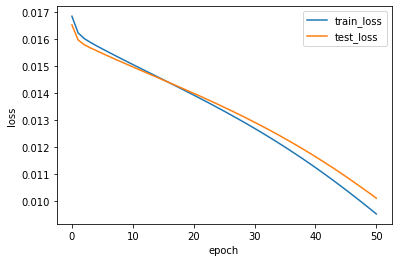

In [12]:
x = np.linspace(0,len(train_loss),len(train_loss))
plt.plot(x,train_loss,label="train_loss",linewidth=1.5)
plt.plot(x,test_loss,label="test_loss",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()